<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Base/HW2_Gradient_descent_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Домашнее задание: Градиентный спуск — базовые концепции**


В этом домашнем задании вы попрактикуетесь в двух вещах:

1. **Градиентный спуск**
   Вы реализуете базовый GD, закрепите на практике его свойства и научитесь интерпретировать результаты.

2. **Дебаггинг**
   По ходу выполнения заданий вам потребуется выявлять и исправлять ошибки — в паре мест — в программной реализации.

##### **Почему дебаггинг?**

На практике, особенно часто при работе с обучением моделей придется читать ошибки и обеспечивать совместимость своего кода с написанным ранее. При этом, написанный ранее код может быть написан не идеально — не важно LLM его писала или человек.

В этом домашнем задании вы:

* реализуете класс GD с треккингом лосса и градиентов;
* проверите, корректно ли ваш оптимизатор работает на разных функциях (в том числе на не выпуклых!);
* потренируетесь читать графики loss;
* получите много красивых визуализаций;

**Ошибки только в функции для графиков!**

**Дедлайн: 13 декабря 23:59**



In [313]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(42)

### **Функция для картинок**

Эта функция для красивых графиков. Разберитесь в ее работе (можно - при помощи LLM).

<font color="red">В функции в двух местах преднамеренно допущены ошибки. Исправьте их. </font>

In [ ]:
# Эта функция для красивых графиков
def plot_gd_3d(x_range, y_range, Z, loss_fn, history_dict,
               title="Градиентный спуск (3D)", min_point=None):
    """
    3D-график: поверхность + траектории градиентного спуска.

    x_range, y_range : 1D np.array
        Диапазоны по осям x и y.
    Z : 2D np.array
        Значения функции на сетке (len(y_range), len(x_range)).
    loss_fn : callable
        Функция потерь f(params) -> float, чтобы считать z вдоль траекторий.
    history_dict : dict[str, history]
        Словарь: метка -> history, где history['params'] — список параметров.
        Например: {"LR=0.1": gd.history, "LR=0.01": gd2.history}
    min_point : tuple (x*, y*) или None
        Если задано, отмечаем минимум на графике.
    """
    fig = go.Figure()

    # Поверхность функции
    fig.add_trace(
        go.Surface(
            x=x_range,
            y=y_range,
            z=Z,
            opacity=0.7,
            showscale=False
        )
    )

    # Траектории
    # считаются по лоссу
    for label, history in history_dict.items():
         trajectory = np.array(history["params"])  # shape: (T, 2)
         x_traj = trajectory[:, 0]
         y_traj = trajectory[:, 1]
         z_traj = np.array([loss_fn(np.array(p)) for p in trajectory])

         fig.add_trace(
             go.Scatter3d(
                 x=x_traj,
                 y=y_traj,
                 z=z_traj,
                 mode='lines+markers',
                 name=label,
                 marker=dict(size=4),
                 line=dict(width=2)
             )
         )

         # Стартовые точки
         fig.add_trace(
            go.Scatter3d(
                x=x_traj[0:1],
                y=y_traj[0:1],
                z=z_traj[0:1],
                mode='markers',
                name=f'Start {label}',
                marker=dict(size=5, symbol='x')
            )
         )

    # Минимум, если задан
    if min_point is not None:
        x_min, y_min = min_point
        fig.add_trace(
            go.Scatter3d(
                x=[x_min],
                y=[y_min],
                z=[loss_fn(np.array([x_min, y_min]))],
                mode='markers',
                name='Минимум',
                marker=dict(size=6, symbol='diamond-open')
            )
        )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="f(x, y)"
        ),
        height=700,
        width=2200
    )

    fig.show()


def plot_gd_2d(x_range, y_range, Z, history_dict,
               title="Градиентный спуск (2D контуры)",
               start_points=None, min_point=None,
               contour_kwargs=None):
    """
    2D-контуры + траектории градиентного спуска.

    x_range, y_range : 1D np.array
    Z : 2D np.array
    history_dict : dict[str, history]
        метка -> history, где history['params'] — список параметров.
    start_points : list[np.array] или None
        Список стартовых точек (x0, y0), чтобы нарисовать их на графике.
    min_point : tuple (x*, y*) или None
        Если задано, отмечаем минимум.
    contour_kwargs : dict или None
        Доп. параметры для go.Contour (contours=..., opacity=..., ...).
    """
    if contour_kwargs is None:
        contour_kwargs = dict(
            colorscale='Viridis',
            showscale=False,
            contours=dict(start=0, end=30, size=2),
            opacity=0.7
        )

    fig = go.Figure()

    # Контурный график функции
    fig.add_trace(
        go.Contour(
            x=x_range,
            y=y_range,
            z=Z,
            **contour_kwargs
        )
    )

    # Траектории
    for label, history in history_dict.items():
         trajectory = np.array(history["params"])
         fig.add_trace(
             go.Scatter(
                 x=trajectory[:, 0],
                 y=trajectory[:, 1],
                 mode='lines+markers',
                 name=label,
                 marker=dict(size=5),
                 line=dict(width=3)
             )
         )

    # Стартовые точки (если переданы отдельно)
    # точка имеет
    if start_points is not None:
        for i, p0 in enumerate(start_points):
            fig.add_trace(
                go.Scatter(
                    x=[p0[0]],
                    y=[p0[0]],
                    mode='markers',
                    name=f'Start {i+1}',
                    marker=dict(size=10, symbol='x')
                )
            )

    # Минимум
    if min_point is not None:
        x_min, y_min = min_point
        fig.add_trace(
            go.Scatter(
                x=[x_min],
                y=[y_min],
                mode='markers',
                name='Минимум',
                marker=dict(size=10, symbol='diamond-open')
            )
        )

    fig.update_layout(
        title=title,
        xaxis_title="x",
        yaxis_title="y",
        height=700
    )

    fig.show()

### **Задание 1. Градиентный спуск: постановка задачи (3 балла)**


Напомним, что в задачах машинного обучения мы хотим минимизировать **функцию потерь**
$$L(w): \mathbb{R}^d \to \mathbb{R},$$
где $w \in \mathbb{R}^d$ — вектор параметров модели (веса), а $L$ измеряет качество этой модели на данных. Пострейший пример функции потерь — MSE потери. Если мы обозначим за $y_i$ истинный прогноз, а за $\hat{y}$ — предсказанный моделью, то MSE — функция вида:

$$L(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (y - \hat{y})^2$$

Если функция потерь дифференцируема, один из базовых численных методов для её минимизации — **градиентный спуск** (Gradient Descent). Если же функция потерь дифференцируема не везде — мы используем в "плохих точках" [субградиент](https://www.google.com/search?client=safari&rls=en&q=%D0%A1%D1%83%D0%B1%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82&ie=UTF-8&oe=UTF-8).

#### **Идея метода градиетного спуска**

Градиент $\nabla L(w)$ по определению показывает направление **наискорейшего роста** функции. Чтобы уменьшать значение $L(w)$, нужно двигаться в противоположную сторону — туда, где функция убывает:

$$w_{k+1} = w_k - \eta \nabla L(w_k),$$

где

* $w_k$ — параметры на итерации $k$,
* $\eta > 0$ — шаг обучения (learning rate),
* $\nabla L(w_k)$ — градиент функции потерь по параметрам $w$ в точке $w_k$.

При достаточно «хороших» свойствах $L(w)$ (выпуклость — можно обозвать это "парабольным" поведением и гладкость — дифференцируемость везде) и правильно подобранном шаге $\eta$ последовательность ${w_k}$ будет стремиться к точке минимума. На практике, свойства функции мы проверяем не всегда, так как используем золотой набор функций устоявшийся в области и ключевую роль играет шаг $\eta$.

#### **Детали? Детали!**

При реализации градиентного спуска нужно учитывать:

1. **Инициализацию**

   Необходимо задать начальное значение параметров $w_0$.

2. **Шаг обучения $\eta$**

     Его правильный подбор — это искусство.

3. **Критерии остановки**

   Обычно метод выполняется фиксированное число итераций $N$, либо пока не выполнится одно из условий:

   * $|\nabla L(w_k)|$ стало достаточно малым;
   * изменение параметров $|w_{k+1} - w_k|$ мало;
   * изменение значения потерь $|L(w_{k+1}) - L(w_k)|$ мало.

4. **История обучения**

   Для анализа работы алгоритма полезно сохранять:

   * значения параметров $w_k$ на каждой итерации;
   * значения функции потерь $L(w_k)$;
   * (не обязательно, но полезно) значения нормы градиента $|\nabla L(w_k)|$.

    Эта информация позволит визуализировать траекторию спуска и поведение loss-функции во времени. Когда у нас есть этот график (да и вообще все 3 из перечисленных), мы можем понимать, как у обучения дела.


#### **1. Выпуклость и нет (1.5 балла)**

Из теории мы также знаем, что хочется минимизировать **выпуклые функции**. Почему именно их? Они приятные и у них:

* либо один глобальный минимум,
* либо целое выпуклое множество глобальных минимумов,
* нет локальных минимумов.

Это означает, что при разумном шаге градиентный спуск, стартуя из любой точки, будет стремиться к глобальному минимуму.

Формально, функция $f:\mathbb{R}^d \to \mathbb{R}$ называется **выпуклой**, если для любых $x, y \in \mathbb{R}^d$ и $\lambda \in [0, 1]$:
$$f(\lambda x + (1-\lambda) y) \leq \lambda f(x) + (1-\lambda) f(y)$$

Для дважды дифференцируемых функций это эквивалентно тому, что их **матрица Гессе** (матрица вторых производных) неотрицательно определена во всех точках.

Но это всё детали. Которые полезно знать. Но в реальных задачах машинного обучения мы почти всегда сталкиваемся с **невыпуклыми** функциями потерь.

Уметь понимать поведение на выпуклом и невыпуклом ландшафте по лоссу/градиенту важно, потому что это поможет вам в будущем изучать графики ваших моделей более четко и понимать, почему обучение застряло и что с этим можно сделать (добавить инерцию, перестартануть с других точек и так далее). Что же, давайте знакомиться с разным поведением!

#### **1. 1. Задание: реализуйте в коде функции и их градиенты**

1. **Простая квадратичная функция** (выпуклая):
   
   $f(x, y) = x^2 + y^2.$

2. **Функция Розенброка ([Rosenbrock's banana function](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A0%D0%BE%D0%B7%D0%B5%D0%BD%D0%B1%D1%80%D0%BE%D0%BA%D0%B0))**:

   $f_{\text{R}}(x, y) = (a - x)^2 + b(y - x^2)^2$, тут по умолчанию a=1, b=100, но далее надо реализовывать a и b как гиперпараметры.

Мы будем использовать эти функции дальше для визуализации траекторий градиентного спуска, сравнения влияния шага обучения и анализа ландшафта.

**Ваши задачи в этом подпункте:**

1. Реализовать функции:

   * `quadratic_loss(params)`
   * `rosenbrock_loss(params, a=1, b=100)`

2. Реализовать их градиенты:

   * `quadratic_grad(params)` — возвращает `[grad_x, grad_y]`
   * `rosenbrock_grad(params, a=1, b=100)` — возвращает `[grad_x, grad_y]`


Дальше эти функции будут использоваться в классе `GradientDescent` для экспериментов с разными значениями шага обучения и для 2D/3D визуализаций ландшафта.



In [315]:
# Квадратичная функция
def quadratic_loss(params):
  """
  params: list — список, вида [x, y]
  f(x, y) = x^2 + y^2
  """
  x, y = params
  return x**2 + y**2

def quadratic_grad(params):
    """Градиент"""
    x, y = params
    return [2*x, 2*y]

# Функция Розенброка
def rosenbrock_loss(params, a=1, b=100):
    """
    params: list — список, вида [x, y]
    f(x, y) = (a - x)^2 + b(y - x^2)^2
    """
    x, y = params
    return (a - x)**2 + b*(y - x**2)**2

def rosenbrock_grad(params, a=1, b=100):
    """Градиент функции Розенброка"""
    x, y = params
    return [-2*(a - x) - 4*b*x*(y - x**2), 2*b*(y - x**2)]


#### **1. 2. Реализуйте классический (ванильный) градиентный спуск (1.5 балла)**

Теперь давайте сделаем **класс градиентного спуска** `GradientDescent`, в котором будет помимо прочего реализовано подробное логирование. Все параметры, которые класс принимает на вход, описаны ниже и соответствуют теоретической постановке задачи.

In [316]:
class GradientDescent:

    """Ваш класс для базовой реализации градиентного спуска
    learning_rate: float - скорость спуска
    n_iterations: int - максимальное количество итераций спуска
    history: dict - словарь, который будет хранить историю обучения
    """

    # Ваш код здесь
    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.history = {
            'params': [],
            'loss': [],
            'gradients': []
        }

    def fit(self, loss_fn, grad_fn, initial_params):
        """
        Обучение с помощью GD

            loss_fn: функция потерь
            grad_fn: функция градиента
            initial_params: начальные параметры
        """
        params = initial_params.copy()

        for _ in range(self.n_iterations):            
            # Вычисляем градиент
            grad_params = grad_fn(params)            
            
            self.history['params'].append(params.copy()) # ваш код здесь
            self.history['loss'].append(loss_fn(params))# ваш код здесь
            self.history['gradients'].append(grad_params.copy()) # ваш код здесь

            # ваш код здесь
            params = [p -  self.learning_rate * g for p, g in zip(params, grad_params)]

        # Сохраняем финальное состояние
        self.history['params'].append(params.copy()) # ваш код здесь
        self.history['loss'].append(loss_fn(params))# ваш код здесь
        self.history['gradients'].append(grad_fn(params)) # ваш код здесь

        return params


Теперь проверим работоспособность функций, но если вы сделали это выше при реализации — вам только плюсы!

Мы будем использовать библиотеку plotly, чтобы получить функциональные графики — которые можно приближать, отдалять, крутить и так далее. Нарисуем полученные функции в 3D и протестируем градиентный спуск. Вернее, его параметры.

### **Задание 2. Анализ гиперпараметров градиетного спуска (2 балла)**


Learning rate (в разных нотациях его обозначают за $\eta или \alpha$) — основной гиперпараметр градиетного спуска и любой его модификации. Даже для простой выпуклой функции (например, квадратичной) заведомо неверный выбор шага делает обучение неэффективным или просто расходящимся.

Давайте проанализруем влияние шага обучения на поведение градиентного спуска.
Для этого:

1. Возьмите несколько значений learning rate:
   $$\eta \in \{0.001,\ 0.01,\ 0.1,\ 0.5,\ 1.0\}.$$

2. Возьмите несколько стартовых точек.
   
3. Протестируйте работу реализованного класса работу на двух функциях:

   * выпуклой функции
     $$f(x, y) = x^2 + y^2,$$
   * невыпуклой функции Розенброка
     $$f(x, y) = (1 - x)^2 + 100 (y - x^2)^2$$
4. Сделайте выводы.


In [317]:
# Код для тестирования градиентного спуска с разными learning rates

learning_rates = [0.001, 0.1, 0.5, 0.9]
initial_point = np.array([1.0, 1.0])

# Сетка для визуализации функции
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 + Y**2  # квадратичная поверхность

results_lr_quadr = {}

# Запускаем градиентный спуск для всех LR и сохраняем историю
for lr in learning_rates:
    # ваш код здесь — не забудьте запистаь результаты
    gd = GradientDescent(lr, n_iterations=100)
    final_params = gd.fit(quadratic_loss, quadratic_grad, initial_point)    
    results_lr_quadr[lr] = gd.history

    print(f"LR = {lr}: Final loss = {quadratic_loss(final_params):.6f}, "
          f"Final params = [{final_params[0]:.4f}, {final_params[1]:.4f}]")


LR = 0.001: Final loss = 1.340103, Final params = [0.8186, 0.8186]
LR = 0.1: Final loss = 0.000000, Final params = [0.0000, 0.0000]
LR = 0.5: Final loss = 0.000000, Final params = [0.0000, 0.0000]
LR = 0.9: Final loss = 0.000000, Final params = [0.0000, 0.0000]


In [318]:
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=quadratic_loss,
    history_dict=results_lr_quadr,
    title="Квадратичная функция: траектории GD (3D)",
    min_point=(0.0, 0.0)
)

plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=results_lr_quadr,
    title="Квадратичная функция: траектории GD (2D контуры)",
    start_points=[initial_point],
    min_point=(0.0, 0.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=30, size=2),
        opacity=0.7
    )
)


In [319]:
# Сетка для визуализации функции Розенброка
x_range = np.linspace(-2, 2, 200)
y_range = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Запуск градиентного спуска
initial_point = np.array([-0.5, 0.5])

results_lr_banna = {}

# Запускаем градиентный спуск для всех LR и сохраняем историю
for lr in learning_rates:
    # ваш код здесь — не забудьте запистаь результаты
    gd = GradientDescent(lr, n_iterations=100)
    final_rosen = gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point)    
    results_lr_banna[lr] = gd.history

    print(f"Final Rosenbrock loss = {rosenbrock_loss(final_rosen):.6f}, "
      f"Final params = [{final_rosen[0]:.4f}, {final_rosen[1]:.4f}]")


Final Rosenbrock loss = 2.190085, Final params = [-0.4780, 0.2359]
Final Rosenbrock loss = nan, Final params = [nan, nan]
Final Rosenbrock loss = nan, Final params = [nan, nan]
Final Rosenbrock loss = nan, Final params = [nan, nan]


C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:22: RuntimeWarning:

overflow encountered in scalar power

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\2737544392.py:38: RuntimeWarning:

invalid value encountered in scalar subtract

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

overflow encountered in scalar power

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

invalid value encountered in scalar subtract

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:22: RuntimeWarning:

invalid value encountered in scalar subtract



In [320]:
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=rosenbrock_loss,
    history_dict=results_lr_quadr,
    title="Rosenbrock функция: траектории GD (3D)",
    min_point=(0.0, 0.0)
)

plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=results_lr_quadr,
    title="Rosenbrock функция: траектории GD (2D контуры)",
    start_points=[initial_point],
    min_point=(0.0, 0.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=30, size=2),
        opacity=0.7
    )
)


**Ваши выводы здесь**

Хорошо видно как именно влияют на результат выбор параметров градиентного спуска:
1. Если шаг обучения слишком маленький (0.001), то за заявленное количество итераций не удается достичь реального минимума. Очевидно, что для достижении результата будет необходимо как-то определять, что мы еще не доехали и увеличивать количество итераций. Это ведет к дополнительным вычислительным затратам и стоймости поиска в том числе и по времени.
2. Так же видно, что слишком большой шаг обучения (0.9) приводит к значительным перескокам через миниммум и возвратам. То есть скорость приближения к миниммум остается достаточно маленькой. 
3. Дополнительная особенность (видна на Розенброке). Градиентный спуск чувствителен к топологии поверхности. Если поверхность имеет слабовыраженный градиент (типа ложбины), либо экстремальный градиент, мы так же можем и не попасть в минимум - высока вероятность расхождения. 
4. Начальная точка так же очень важна. При наличии нескольких ложных минимуммов очевидно требуется пересчитывать спуск из рандомных точек поверхности несколько раз для уточнения, что так же влечет дополнительные ресурсы и время. 

Все это сипринципиально влияет на сходимость

### **Задание 3. Анализ Losses (2 балла)**

Реализованный вами класс также сохранял графики loss-функции. Их в процессе обучения мы также анализируем. Говорят, что **loss “сходится”**, если выполняются следующие признаки:

1. Значение loss $L(w_k)$ монотонно убывает и приближается к некоторому предельному значению (выходит на плато):
   $$|L(w_{k+1}) - L(w_k)| \to 0$$

Сошелся ли лосс у нас? Для ответы используйте реализованные вами методы из заданий 1–2:

In [321]:
for lr in learning_rates:
    print(f'-- results_lr_quadr: {lr} ---------')
    for x,y in results_lr_quadr[lr]['params'][-5:]:
        print(f'{x}:{y}')

for lr in learning_rates:
    print(f'-- results_lr_banna: {lr} ---------')
    for x,y in results_lr_banna[lr]['params'][-3:]:
        print(f'{x}:{y}')


# По результам видим, что по Квадратичной поверхности:
#    на Lr = 0.5 спуск сошелся, 0.001 совсем нет, 0.1, 0.9 - близки к схождению

# По результам видим, что по Розенброк поверхности:
# На 0.001 - спуск сошелся, на 0.1, 0.5, 0.9 видим, что градиент расходится

-- results_lr_quadr: 0.001 ---------
0.8251482132286804:0.8251482132286804
0.8234979168022231:0.8234979168022231
0.8218509209686187:0.8218509209686187
0.8202072191266815:0.8202072191266815
0.8185668046884281:0.8185668046884281
-- results_lr_quadr: 0.1 ---------
4.97323236409787e-10:4.97323236409787e-10
3.978585891278296e-10:3.978585891278296e-10
3.182868713022637e-10:3.182868713022637e-10
2.5462949704181097e-10:2.5462949704181097e-10
2.0370359763344877e-10:2.0370359763344877e-10
-- results_lr_quadr: 0.5 ---------
0.0:0.0
0.0:0.0
0.0:0.0
0.0:0.0
0.0:0.0
-- results_lr_quadr: 0.9 ---------
4.973232364097895e-10:4.973232364097895e-10
-3.9785858912783165e-10:-3.9785858912783165e-10
3.1828687130226534e-10:3.1828687130226534e-10
-2.546294970418123e-10:-2.546294970418123e-10
2.0370359763344985e-10:2.0370359763344985e-10
-- results_lr_banna: 0.001 ---------
-0.48111629450990345:0.23888856691182442
-0.47958118334239563:0.23740543129804756
-0.47804298546946433:0.23592396732165655
-- results_lr_ba

1. **Постройте графики значения loss по итерациям** для:

   * квадратичной функции,
   * функции Розенброка,
   * для всех значений learning rate, что и в заданиях выше ($\eta \in \{0.001, 0.01, 0.1, 0.5\}$).

   

2. **В каждой серии экспериментов**:

   * сравните, как меняется форма графика loss при разных $\eta$;
   * отметьте, где кривая loss ведёт себя “хорошо” (гладкое убывание) и где “плохо” (скачки, рост, колебания, плато).
   * где мы сошлись, а где — нет.

3. **Проанализируйте различия** между функциями.

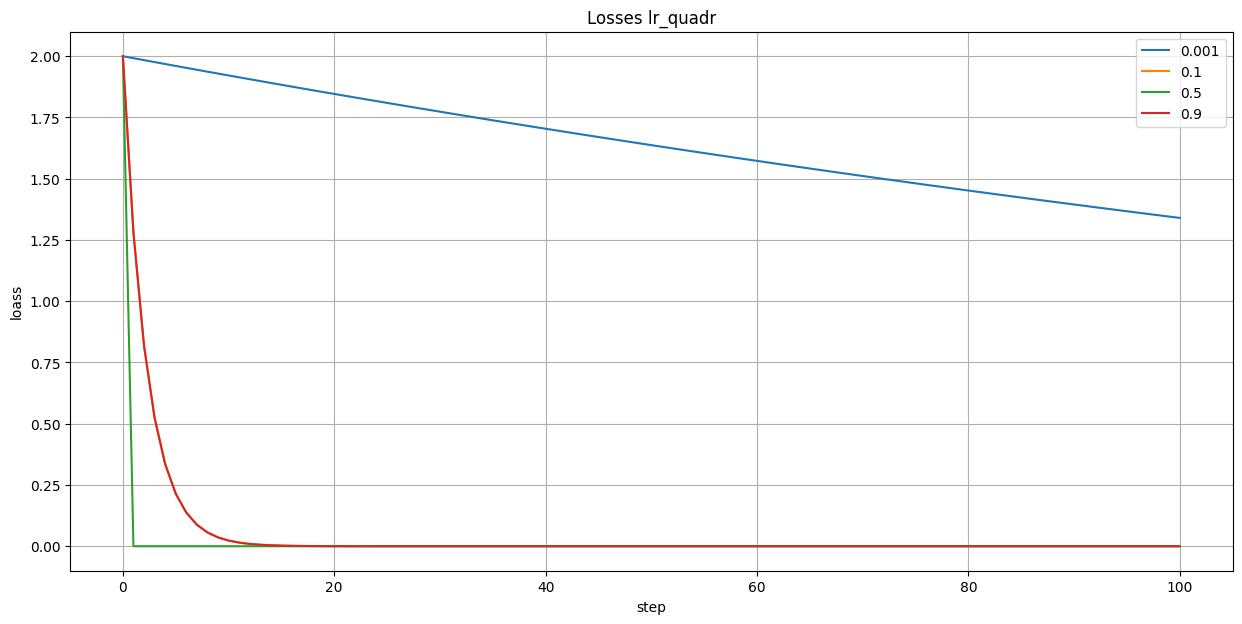

In [322]:
plt.figure(figsize=(15, 7))

for lr in learning_rates:
    data = results_lr_quadr[lr]['loss']
    steps = list(range(len(data)))
    plt.plot(steps, data, label=f'{lr}')

plt.legend()
plt.xlabel('step')
plt.ylabel('loass')
plt.title('Losses lr_quadr')
plt.grid(True)
plt.show()

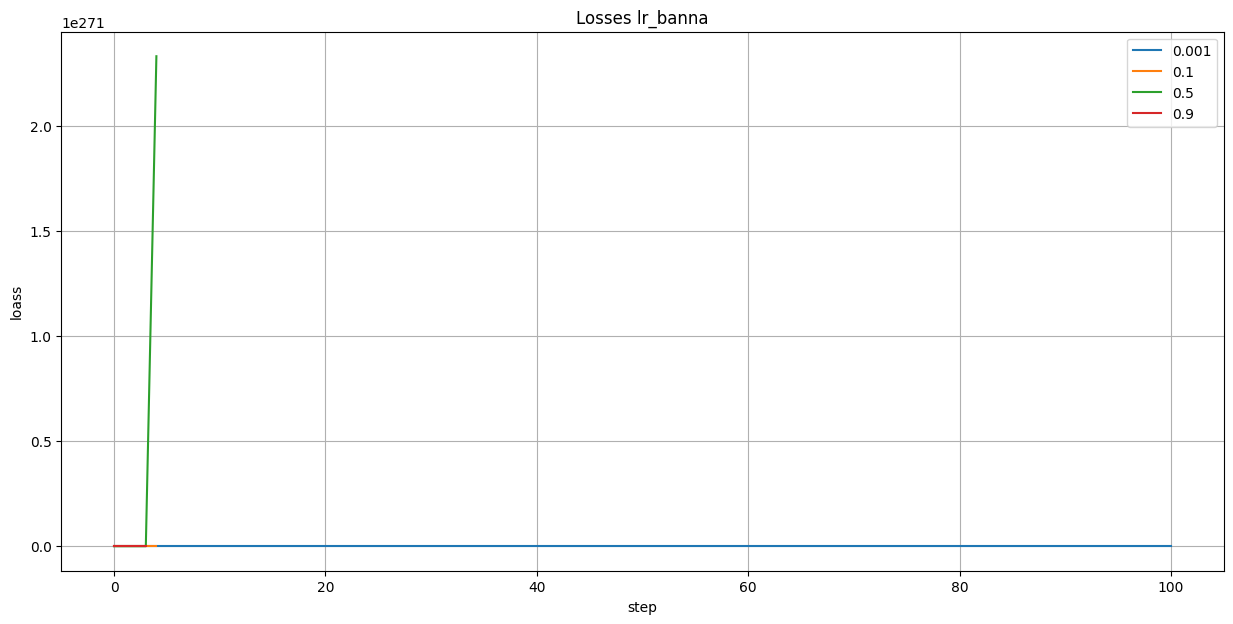

In [323]:
plt.figure(figsize=(15, 7))

for lr in learning_rates:
    data = results_lr_banna[lr]['loss']
    steps = list(range(len(data)))
    plt.plot(steps, data, label=f'{lr}')

plt.legend()
plt.xlabel('step')
plt.ylabel('loass')
plt.title('Losses lr_banna')
plt.grid(True)
plt.show()

## Выводы:

### Квадратичная поверхность

Графики гладкие. Видно, что там, где не сошелся - не хватило итераций (LR=0.001). При LR = 0.5 сразу повезло и мы почти точно попали куда надо. При 0.9 график гладкий (хотя как мы уже выяснили мы перепрыгивали через миниммум) и предсказуем. LR = 0.1 График эквивалентен 0.9, просто без перескоков.

### Банановая Розенброк поверхность:
Спуск сошелся только при LR=0.001, В остальных случаях видим резкое расхождение. Банановую поверхность просто так не победить, либо через очень затратные микрошаги. 

### **Задание 4. Расписания для learning rate и победа над бананами (3 балла)**

В предыдущих заданиях мы рассматривали градиентный спуск с постоянным шагом обучения

$$w_{k+1} = w_k - \eta\nabla L(w_k),$$
где $\eta$ (learning rate) — фиксированная константа. Но графики функций выше вблизи минимумов наталкивают на ледующую интуицию (встречающуюся очень часто) —  в начале обучения продуктивнее делать большие шаги, чтобы быстро “спуститься” с вершины/плато, ближе к минимуму шаг нужно уменьшать, чтобы не перепрыгнуть минимум.

Чтобы реализовать эту идею, на практике почти всегда используют расписание для шага обучения (learning rate schedules): $\eta$ делают зависящим от номера итерации:

$$\eta_k = \eta(k), \quad k = 0, 1, 2, \dots$$

Даже в самых сложных модификациях градиентного спуска (Momentum, Adam, Adagrad, RMSProp и т.п.) всегда есть базовый learning rate ((\eta), (\alpha)) и “соседние” гиперпараметры, которые управляют эффективным шагом, так что идея “шаг со временем меняется” присутствует всегда, даже если она спрятана в более сложной формуле.

**Варианты расписаний:**

1. **Step decay (ступенчатое уменьшение):**
   $$
   \eta_k =
   \begin{cases}
   \eta_0, & k < k_1, \\
   \eta_0 \cdot \gamma, & k_1 \le k < k_2 \\
   \eta_0 \cdot \gamma^2, & k \ge k_2.
   \end{cases}
   $$

2. **Exponential decay:**
   
   $$\eta_k = \eta_0 \cdot \gamma^k, \quad 0 < \gamma < 1.$$

3. **Inverse time decay:**
   $$\eta_k = \frac{\eta_0}{1 + \lambda k}.$$

и на самом деле — безумно много других — cosine decay, warm restarts и т.п.. Вам не нужно их заучивать, но важно их знать, чтобы понимать, как улучшать свои решения. Поэтому давайте сделаем простое расписание своими руками.

#### **4.1 Реализация расписания (1.5 балла)**

1. **Модифицируйте класс `GradientDescent`** так, чтобы он поддерживал **расписание шага обучения — inverse time decay**.



In [324]:
class GradientDescentWithScheduler:
    """
    Градиентный спуск с опциональным расписанием learning rate.

    Параметры
    ---------
    learning_rate : float — базовый шаг обучения η_0.
    n_iterations : int — число итераций.
    decay : float или None
        если decay is None — шаг обучения постоянный: η_k = η_0.
        если decay > 0 — inverse time decay:
            η_k = η_0 / (1 + decay * k),
        где k — номер итерации (0, 1, 2, ...).

    Пример вызовы:
    -------
    # постоянный шаг
    gd_const = GradientDescentWithScheduler(learning_rate=0.01, n_iterations=1000)

    # убывающий шаг
    gd_decay = GradientDescentWithScheduler(learning_rate=0.01, n_iterations=1000, decay=0.001)
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, decay=None):
        self.learning_rate = float(learning_rate)
        self.n_iterations = int(n_iterations)
        self.decay = decay

        # сюда будем сохранять историю обучения
        self.history = {}

    def fit(self, loss_fn, grad_fn, initial_params):
        """
        Запустить градиентный спуск.

        Параметры
        ---------
        loss_fn : callable
            Функция потерь L(w): np.array -> float.
        grad_fn : callable
            Градиент ∇L(w): np.array - np.array той же размерности.
        initial_params : array-like
            Начальный вектор параметров w_0.

        Возвращает
        params : np.ndarray
            Финальные параметры после n_iterations.
        """
        params = np.array(initial_params, dtype=float)

        params_history = []
        loss_history = []
        lr_history = []

        for k in range(self.n_iterations):
            # шаг обучения на текущей итерации
            if self.decay is None:
                lr_k = self.learning_rate
            else:
                # η_k = η_0 / (1 + decay * k):
                lr_k = self.learning_rate / (1 + self.decay * k)

            # Вычисляем градиент
            grad_params = grad_fn(params)
            # ваш код здесь
            next_step_params = [p -  lr_k * g for p, g in zip(params, grad_params)]
            
            params_history.append(params) # ваш код здесь
            loss_history.append(loss_fn(params))# ваш код здесь
            lr_history.append(lr_k) # ваш код здесь

            # Обновляем параметры
            params = next_step_params

        self.history = {
            "params": params_history,
            "loss": loss_history,
            "lr": lr_history
        }
        return params


#### **4.2 Победа над сложным минимумом (1.5 балла)**

1. **Сравните поведение градиентного спуска с постоянным lr и с расписанием lr** на функции Розенброка:

   * стартуйте из точки, фиксированной в коде с фиксрованным lr
   * запустите:

     * градиентный спуск с **постоянным** шагом $η = η_0$;
     * градиентный спуск с **убывающим** шагом $η_k$ (exponential decay или inverse time decay).

2. **Для каждого варианта:**

   * постройте 2D-контурный график функции Розенброка с траекторией;
   * постройте 3D-график ландшафта с траекторией;
   * постройте график значения loss по итерациям.

3. **Сделайте выводы. Опишите всё, что вы поняли о спуске из заданий.**

In [325]:
initial_point = np.array([0.3, 3])

# Подберите для этой точки оптимальный decay и lr, чтобы получить ошибку с расписанием < 0.05 (это реально)
# Подбираем lr как [0.001 — 0.01]
lr = 0.001 #  ваш код здесь
min_final_const = None
min_lr = None

for i in range(100):
    gd = GradientDescentWithScheduler(learning_rate=lr)
    final_const = gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point)
    loss = rosenbrock_loss(final_const)
    if min_final_const is None or min_final_const > loss:
        min_final_const = loss
        min_lr = lr
    lr += 0.001

# Постоянный learning rate, используем подобранный:
print(f'Постоянный learning rate (подобранный) = {min_lr}')
gd_const = GradientDescentWithScheduler(learning_rate=min_lr)
final_const = gd_const.fit(rosenbrock_loss, rosenbrock_grad, initial_point)
print(final_const)

print("Постоянный lr: ", final_const, rosenbrock_loss(final_const))

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

overflow encountered in scalar power

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:22: RuntimeWarning:

overflow encountered in scalar power

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

invalid value encountered in scalar subtract

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:22: RuntimeWarning:

invalid value encountered in scalar subtract

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\4118694256.py:65: RuntimeWarning:

invalid value encountered in scalar subtract



Постоянный learning rate (подобранный) = 0.002
[0.7933517057034486, 0.628473919960472]
Постоянный lr:  [0.7933517057034486, 0.628473919960472] 0.04279056811174193


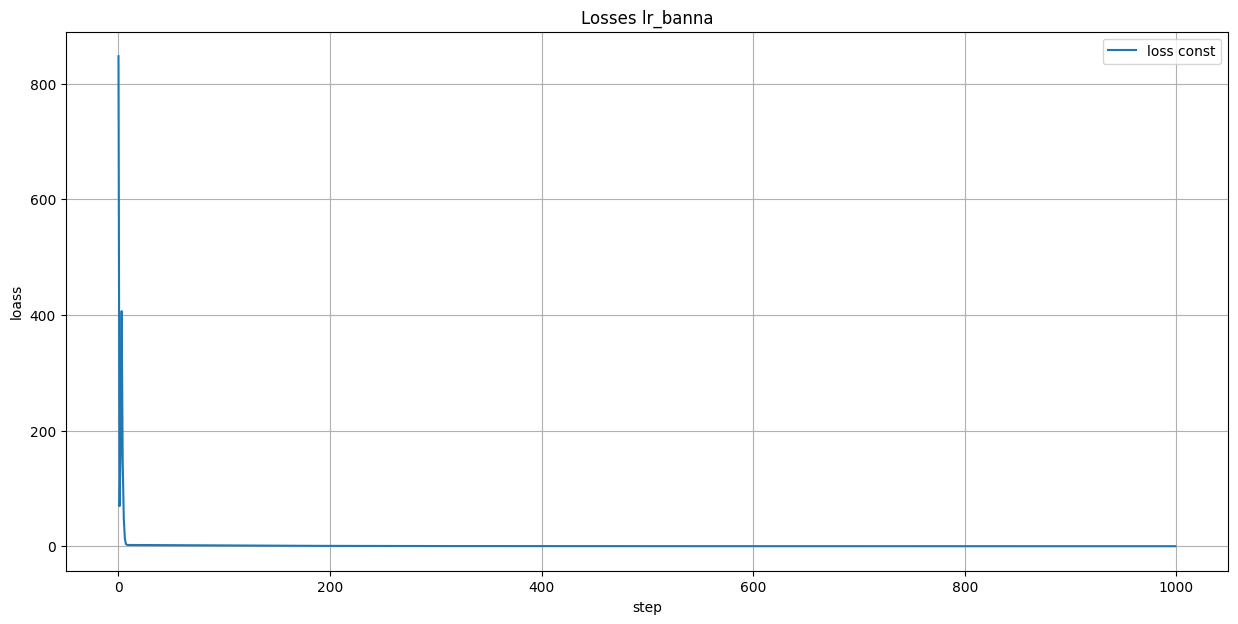

In [326]:
plt.figure(figsize=(15, 7))

data_const = gd_const.history['loss']
steps = list(range(len(data_const)))
plt.plot(steps, data_const, label='loss const')

plt.legend()
plt.xlabel('step')
plt.ylabel('loass')
plt.title('Losses lr_banna')
plt.grid(True)
plt.show()

In [327]:
# Убывающий learning rate
lr = 0.001 #  ваш код здесь
min_final_const = None
min_lr = None
min_decay = None

for i in range(100):
    # Подбираем decay = [0.9 — 0.99]
    decay = 0.90
    for j in range(10):
        gd = GradientDescentWithScheduler(learning_rate=lr, decay=decay)
        final_const = gd.fit(rosenbrock_loss, rosenbrock_grad, initial_point)
        loss = rosenbrock_loss(final_const)
        if min_final_const is None or min_final_const > loss:
            min_final_const = loss
            min_lr = lr
            min_decay = decay
        decay += 0.1
    lr += 0.001

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

overflow encountered in scalar power

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:22: RuntimeWarning:

overflow encountered in scalar power

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

invalid value encountered in scalar subtract

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:22: RuntimeWarning:

invalid value encountered in scalar subtract

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:27: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\4118694256.py:65: RuntimeWarning:

invalid value encountered in scalar subtract

C:\Users\alex\AppData\Local\Temp\ipykernel_21208\1187212119.py:22: RuntimeWarning:

overflow encountered in scalar multiply



In [328]:
print(f'С расписанием learning rate (подобранный) = {min_lr}, decay = {min_decay}')
gd_decay = GradientDescentWithScheduler(learning_rate=min_lr, decay=min_decay)
final_decay = gd_decay.fit(rosenbrock_loss, rosenbrock_grad, initial_point)

print("С расписанием: ", final_decay, rosenbrock_loss(final_decay))

С расписанием learning rate (подобранный) = 0.003, decay = 0.9
С расписанием:  [1.1304738813572532, 1.2784539728443303] 0.017046741022959864


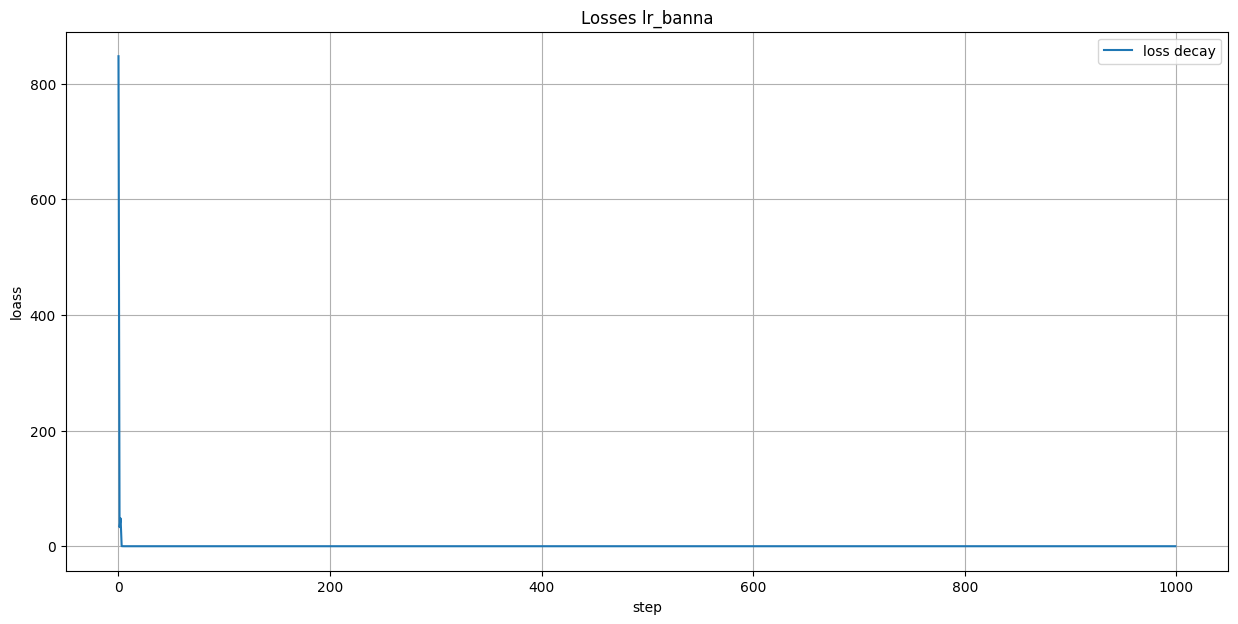

In [329]:
plt.figure(figsize=(15, 7))

data_decay = gd_decay.history['loss']
steps = list(range(len(data_decay)))
plt.plot(steps, data_decay, label='loss decay')

plt.legend()
plt.xlabel('step')
plt.ylabel('loass')
plt.title('Losses lr_banna')
plt.grid(True)
plt.show()

In [330]:
# Сетка для визуализации Розенброка
x_range = np.linspace(-2, 2, 300)
y_range = np.linspace(-1, 3, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Истории для наших двух вариантов GD
history_dict = {
    "Постоянный lr": gd_const.history,
    "Inverse time decay": gd_decay.history
}

# 2D-контуры + траектории
plot_gd_2d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    history_dict=history_dict,
    title="Функция Розенброка: траектории GD (2D контуры)",
    start_points=[initial_point],
    min_point=(1.0, 1.0),
    contour_kwargs=dict(
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=500, size=25),
        opacity=0.7
    )
)

# 3D-поверхность + траектории
plot_gd_3d(
    x_range=x_range,
    y_range=y_range,
    Z=Z,
    loss_fn=rosenbrock_loss,
    history_dict=history_dict,
    title="Функция Розенброка: траектории GD (3D ландшафт)",
    min_point=(1.0, 1.0)
)


**Общие выводы.**

При подборе гипер параметров получились значения:

Постоянный learning rate (подобранный) = 0.002
Достигается в точке: [0.7933517057034486, 0.628473919960472], значение loss = 0.04279056811174193

С расписанием learning rate (подобранный) = 0.003, decay = 0.9
Достигается в точке [1.1304738813572532, 1.2784539728443303], значение loss = 0.017046741022959864

Видим, что при заданых значениях оба варианта достаточно быстро достигают корректной точности, причем с расписанием делает это с кратно большей точностью. Причем заметно меньше итераций требуется для выхода в окрестность минимумма. То есть если бы мы доработали алгоритм и останавливались при достижении заявленной точности, то алгоритм с расписанием еще быстрее работал бы. Постоянный довольно много итераций тратит на 'подоход' с минимуму (хвост рядом стоящих точек)


## **Бонус 0.25 балла**

Проанализируйте график лосс-функции ниже. Попробуйте сформулировать гипотезы:
- Что происходит?
- Что с этим делать?

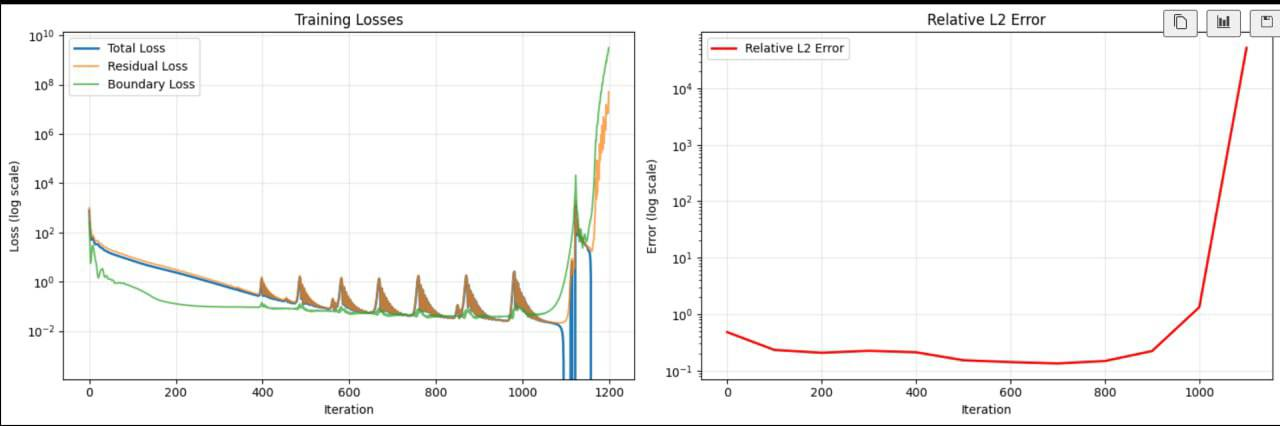

In [331]:
# Диагностируются аномалии:
# 1. Пила на графиках
# 2. Бардак на значениях 1000 - 1200
# 3. Резкое расхождение на итерациях после 1100
# 4. Явный рост ошибки L2 после 800 итерации

# Разберемся с каждой:
# Пила - вероятно это происходит из-за нестабильности градиента. Вероятно он идет вдоль спирали с агрессивными стенками. 
# То есть спуск скачет в ложбине, которая плавно идет вниз. Наличие периодичности сигналит о том, что ширина ложбины постоянна, 
# но глубина возрастает (как достигает стенки ошибка выскочить - повышается). До 400 итерации график гладкий, значит в окрестностях стартовой точки 
# Таких стенок не было и спуск был гладкий. 
# После итерации 1100 явное расхождение, то есть вероятно ложбина заканчивается резкой впадиной с достаточно тонким горлом и очень
# агрессивным градиентом, об этом свидетельствует очень резкий рост ошибки (спуск выскочил из ложбины и вообще вылетел)
# Явный рост относительной ошибки сигналит о том, что начиная с 800 итерации, хоть спуски шел с улучшением, 
# но чуть не в том направлении, возможно ложбины было две и он залез не в тот рукав, который заканчивается 'обрывом', 
# который и привел к резкому выходу спуска из траектории. 


# Выводы:
# 1. Нужно избежать слишком сильного вылета на стенки ложбины. Уменьшение шага вероятно чуть сгладит это
# 2. Видно, что в какой-то момент спуск был относительно рядом с целью. Лучше остановиться в определенной окрестности, 
#   К примеру завести допуск на Loss, после которого мы останавливаемся и не продолжаем итерации.
# 3. Аналогично допуск на L2, остановиться в лучшей окрестности
# 4. Возможно имеет смысл начать с нескольких рандомных точек, что бы исключить заход в неправильный рукав. 
#   Возможно с другой стороны поверхности поверхность будет с не такими агрессивными градиентами. 